In [1]:
import numpy as np
from tqdm import tqdm
from system import (
    s_state,
    t_state,
    states,
    wind_col,
    num_states,
    num_actions,
    init_mdp,
    init_reward,
    to_idx,
    get_valid_actions,
    rows,
    cols,
)
from model import Model
from policy import Policy, PolicyInit, ch_egreedy
from agent import Agent

In [2]:
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=0)

model = Model(mdp, reward)

policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

In [640]:
Q_val = np.random.uniform(-10, -1, (num_states, num_actions))
Q_val[to_idx(t_state)][:] = 0

episodic_reward = []
Qvconvergence = []


gamma = 0.9
alpha = 0.05
epsilon = 0.35
for i in tqdm(range(10000)):
    state = s_state
    tr = 0
    rewards = []
    while True:
        action = ch_egreedy(epsilon, Q_val, state)

        nstate = model.gen_next(state, action)

        r = model.get_reward(state, nstate)
        rewards.append(r)

        valid_actions = get_valid_actions(nstate)

        validqsa = Q_val[to_idx(nstate)][valid_actions]

        nmax = np.max(validqsa)
        Q_val[to_idx(state)][action] = Q_val[to_idx(state)][action] + alpha * (
            (r + gamma * nmax) - Q_val[to_idx(state)][action]
        )

        state = nstate
        if (state == t_state).all():
            break
    
    Qvconvergence.append(Q_val[to_idx(s_state)][4])
    for r in rewards[::-1]:
        tr = gamma * tr + r
    episodic_reward.append(tr)

100%|██████████| 10000/10000 [00:34<00:00, 291.39it/s]


In [641]:
valf = []
for s in states:
    valid_actions = get_valid_actions(s)
    valf.append(np.max(Q_val[to_idx(s)][valid_actions]))
valf = np.array(valf)

for s in states: 
    valid_actions = get_valid_actions(s)
    action = valid_actions[np.argmax(Q_val[to_idx(s)][valid_actions])]
    policy.set_action(s, action)

In [642]:
print(valf[to_idx(s_state)])

-6.189555494607171


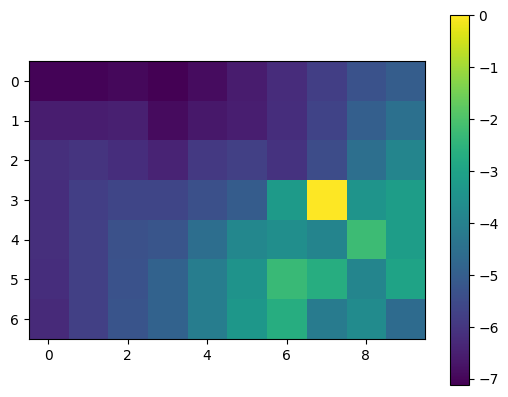

In [643]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

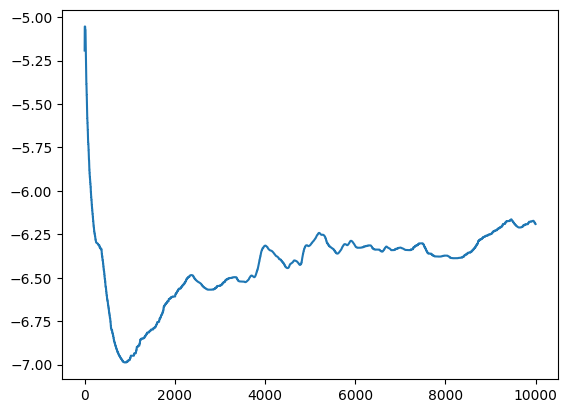

In [644]:
Qvconvergence = np.array(Qvconvergence)
plt.plot(Qvconvergence)

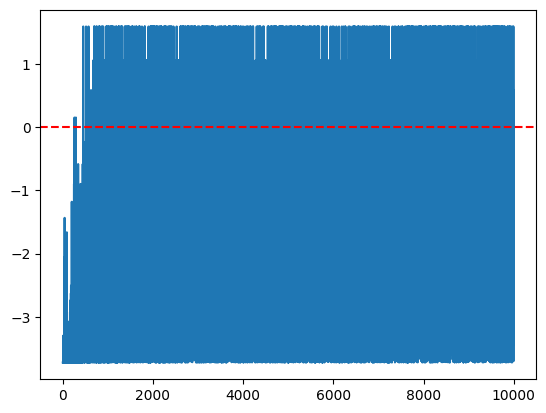

In [645]:
ecreward = np.load('OptimalValueFunction.npy')
episodic_regret = (episodic_reward - ecreward[to_idx(s_state)])
plt.plot(episodic_regret)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

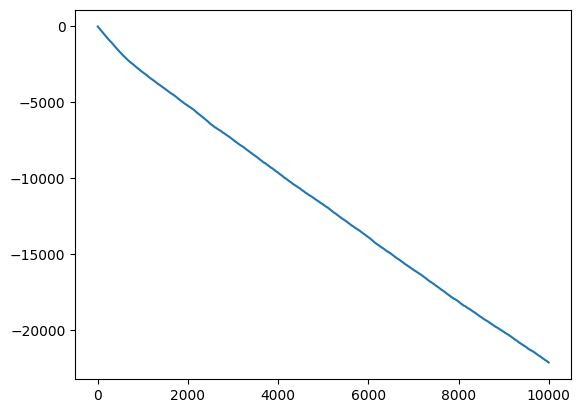

In [646]:
cummulative_regret = np.cumsum(episodic_regret)
plt.plot(cummulative_regret)
plt.show()

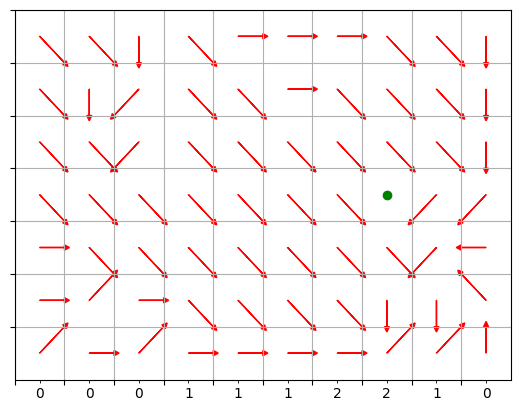

In [647]:
ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

# ## plot 8 types arrows in each grid cell corresponding to the action in the optimal policy
# 0: up-left, 1:up, 2: up-right, 3: left,4: right,5:down-left,6:down,7:down-right
for i in range(rows):
    for j in range(cols):
        s = np.array([i, j])
        action = policy.get_action(s)
        x_start = j + 0.5  # x-coordinate shifted to the middle of the grid cell
        y_start = i + 0.5  # y-coordinate shifted to the middle of the grid cell
        
        if action == 0:
            plt.arrow(x_start, y_start, -0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 1:
            plt.arrow(x_start, y_start, 0, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 2:
            plt.arrow(x_start, y_start, 0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 3:
            plt.arrow(x_start, y_start, -0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 4:
            plt.arrow(x_start, y_start, 0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 5:
            plt.arrow(x_start, y_start, -0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 6:
            plt.arrow(x_start, y_start, 0, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 7:
            plt.arrow(x_start, y_start, 0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 8:
            plt.plot(x_start, y_start, 'go')            


In [648]:
agent = Agent(model, policy)
agent.change_policy(policy)
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [1 1], Next State: [4 1], Reward: -1
State: [4 1], Action: [1 1], Next State: [5 2], Reward: -1
State: [5 2], Action: [0 1], Next State: [5 3], Reward: -1
State: [5 3], Action: [1 1], Next State: [4 4], Reward: -1
State: [4 4], Action: [1 1], Next State: [5 5], Reward: -1
State: [5 5], Action: [1 1], Next State: [6 6], Reward: -1
State: [6 6], Action: [0 1], Next State: [4 7], Reward: -1
State: [4 7], Action: [1 1], Next State: [2 8], Reward: -1
State: [2 8], Action: [1 1], Next State: [1 9], Reward: -1
State: [1 9], Action: [1 0], Next State: [2 9], Reward: -1
State: [2 9], Action: [1 0], Next State: [3 9], Reward: -1
State: [3 9], Action: [ 1 -1], Next State: [4 8], Reward: -1
State: [4 8], Action: [ 1 -1], Next State: [5 7], Reward: -1
State: [5 7], Action: [1 0], Next State: [4 7], Reward: -1
State: [4 7], Action: [1 1], Next State: [3 8], Reward: -1
State: [3 8], Action: [ 1 -1], Next State: [3 7], Reward: 0
Game Over - Score: -15


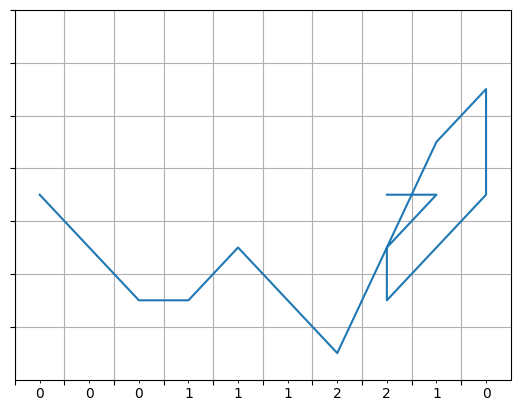

In [649]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()